In [1]:
%pip install numpy
%pip install imblearn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\reche\AppData\Local\Temp\ipykernel_5264\3051588358.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'f': 1, 'r': 0}, inplace=True)  # Convert labels


Cross-Validation F1 Scores: [0.79866989 0.80344304 0.7952595  0.79330848 0.79640477]
Mean F1-Score: 0.7974

🔹 Optimal Threshold: 0.43
Confusion Matrix:
 [[5220 1306]
 [1225 5235]]
Accuracy: 0.8051
Precision: 0.8003
Recall: 0.8104
F1-Score: 0.8053


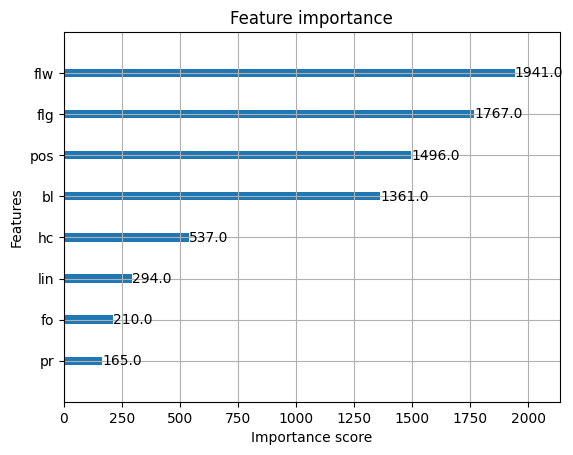

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance

# Load & Clean Data
df = pd.read_csv('data2.csv')
df.replace({'f': 1, 'r': 0}, inplace=True)  # Convert labels
df.drop(columns=['cl', 'cz', 'erl', 'erc', 'lt', 'cs', 'pi', 'ni', 'pic'], inplace=True)
df.fillna(0, inplace=True)
df = df.astype({"pos": 'int', "flw": 'int', "flg": 'int', "bl": 'int', "lin": 'int', 
                "class": 'int', "pr": 'int', "fo": 'int', "hc": 'int'})

# Split Data
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle Class Imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Train Model using Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, 
                      colsample_bytree=0.7, subsample=0.8, random_state=42)

cv_scores = cross_val_score(model, X_train_bal, y_train_bal, cv=skf, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1-Score: {np.mean(cv_scores):.4f}")

# Train Final Model
model.fit(X_train_bal, y_train_bal)

# Predictions with Probabilities
y_probs = model.predict_proba(X_test)[:, 1]  

# Function to Find Best Threshold
def find_best_threshold(y_test, y_probs, metric='f1'):
    best_threshold = 0.5
    best_score = 0
    thresholds = np.arange(0.3, 0.7, 0.01)  # Scanning thresholds from 0.3 to 0.7

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        if metric == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'precision':
            score = precision_score(y_test, y_pred)
        elif metric == 'recall':
            score = recall_score(y_test, y_pred)
        elif metric == 'f1':
            score = f1_score(y_test, y_pred)  # Best for balanced classes
        else:
            raise ValueError("Invalid metric. Choose 'accuracy', 'precision', 'recall', or 'f1'.")

        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold

# Find & Apply Best Threshold Based on F1-Score
optimal_threshold = find_best_threshold(y_test, y_probs, metric='f1')
y_pred_final = (y_probs >= optimal_threshold).astype(int)

# Final Model Evaluation
print(f"\n🔹 Optimal Threshold: {optimal_threshold:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")

# Feature Importance Plot
plot_importance(model)
plt.show()

# Save Model
pickle.dump(model, open('xgb1.sav', 'wb'))


In [5]:
print(accuracy_score(y_test,y_pred_final))

0.805097797628215
